In [23]:
import sys
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)

from tqdm import tqdm
tqdm.pandas()

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_validate

In [83]:
def compute_distance(c1, c2):
    '''
    Compute approx distance between two coords given in (lat, long)
    format. 
    '''
    # approximate radius of earth in km
    R = 6373.0
    lat1 = np.radians(c1[0])
    lon1 = np.radians(c1[1])
    lat2 = np.radians(c2[0])
    lon2 = np.radians(c2[1])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

def test_compute_dist():
    '''
    Unit test for compute_distance function.
    
    Uses Berkeley School of Information and Moscone Center South in San Fransisco
    as a test case. Distance from Google maps. 
    '''
    moscone_south = (37.783957939867015, -122.40107973374062) # lat, long
    i_school = (37.871363468005065, -122.25852213941603) 
    correct_dist = 15.6 # in km
    computed_dist = compute_distance(moscone_south, i_school)
    np.testing.assert_approx_equal(computed_dist, correct_dist, significant=2)

def get_dists_to_articles(country_clust, country_wiki):
    '''
    For a given DHS cluster, get the distance to each of the wiki 
    articles and return it as a numpy array.
    '''
    dists = []
    for i in range(len(country_wiki)):
        dist = compute_distance((country_clust['lat'], country_clust['lon']),
                                (country_wiki['latitude'].iloc[i], country_wiki['longitude'].iloc[i]))
        dists.append(dist)
    return np.array(dists)

def get_closest_n(dists_to_articles, n=10):
    '''
    Get the n closest articles to a given cluster.
    Returns the indices ofthe articles and the approx distances in km.
    '''
    top_inds = np.argsort(dists_to_articles)[:n]
    #np.argpartition(dists_to_articles, n)[:n]
    return top_inds, dists_to_articles[top_inds]

def get_article_feats(country_clust, country_wiki):
    '''
    For a given DHS cluster, get the input tensor that 
    we will feed to the model.
    '''
    embedds = []
    lens = []
    w2vecs = []
    for i, closest_idx in enumerate(country_clust['closest_article_idxs']):
        embedds.append(country_wiki['embedding'].iloc[closest_idx])
        lens.append(country_wiki['len'].iloc[closest_idx])
        w2vecs.append(country_wiki['w2vec'].iloc[closest_idx])
    num_near_articles = \
    country_clust['dists_to_articles'][country_clust['dists_to_articles'] < 10].shape[0]
    lens = torch.flatten(torch.tensor(np.array(lens))).float().numpy()
    dists = torch.tensor(country_clust['closest_article_dists']).float().numpy()
    embedds = torch.flatten(torch.tensor(np.array(embedds))).float().numpy()
    return embedds, dists, lens, num_near_articles, w2vecs

def get_article_feats_pipeline(row, wikis):
    '''
    Extract article features for a row of the DHS survey data, given some global
    curr_country representing the current country and a corresponding article dataframe.
    '''
    country = row['country']
    country_wiki = wikis[country]
    
    country_wiki['len'] = country_wiki['text'].apply(lambda x : np.log2(len(x)))
    
    dists_to_articles = get_dists_to_articles(row, country_wiki)
    closest_article_idxs, closest_article_dists = get_closest_n(np.array(dists_to_articles))
    
    row['dists_to_articles'] = dists_to_articles
    row['closest_article_idxs'] = closest_article_idxs
    row['closest_article_dists'] = closest_article_dists
    
    input_embedds, input_dists, input_lens, input_num, w2vecs = get_article_feats(row, country_wiki)
    
    return closest_article_idxs, input_embedds, input_dists, input_lens, input_num, w2vecs

In [84]:
# Wikipedia2vec stuff:
from wikipedia2vec import Wikipedia2Vec
wiki2vec = Wikipedia2Vec.load("models/enwiki_20180420_win10_100d.pkl")

In [85]:
def get_wiki2vec(title, wiki2vec):
    try:
        return wiki2vec.get_entity_vector(title)
    except:
        return np.zeros(100)

In [86]:
for country, country_wiki in wikis.items():
    avail = 0
    for i in range(len(country_wiki)):
        vec = get_wiki2vec(country_wiki.iloc[i]['title'], wiki2vec)
        if vec.sum() > 0:
            avail += 1
        else:
            print()
    print(f'{country} {avail/len(country_wiki): .4f}')

In [87]:
dhs_clusts = pd.read_csv('dhs_metadata_modified.csv')

countries = list(dhs_clusts['country'].unique())
wikis = {country : pd.read_csv(f'articles/{country}_Wiki.csv') for country in countries}
for country, country_wiki in wikis.items():
    country_wiki['embedding'] = country_wiki['embedding'].apply(lambda x: np.fromstring(x[1:-1], 
                                                                                        sep=' '))
    country_wiki['w2vec'] = country_wiki['title'].apply(lambda x : get_wiki2vec(x, wiki2vec))

dhs_clusts[['article_closest_idxs',
            'article_embeddings', 
            'article_dists', 
            'article_log2_lens',
            'num_near_articles',
            'wikivec']] = \
dhs_clusts.progress_apply(lambda x : get_article_feats_pipeline(x, wikis), 
                          axis=1, result_type='expand')

100%|██████████| 19669/19669 [05:47<00:00, 56.58it/s] 


In [97]:
for country, country_wiki in wikis.items():
    country_wiki.to_csv(f'articles/{country}_Wiki.csv', index=False)

In [101]:
dhs_clusts.drop(columns=['article_embeddings', 'wikivec']).to_csv('dhs_metadata_modified_wikis_np.csv', index=False)

In [31]:
tot_arts = 0
for country, country_wiki in wikis.items():
    tot_arts += len(country_wiki)
print(tot_arts)

11822


<ipython-input-62-54352a8ed46b>:22: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="3%")


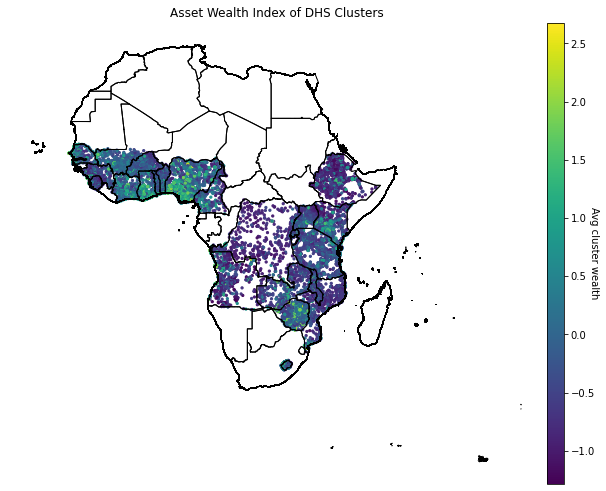

In [62]:
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Plot articles and clusters
shp = gpd.read_file(f'data/africa/Africa_Boundaries.shp') 

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = shp.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
plot = ax.scatter(dhs_clusts['lon'], dhs_clusts['lat'],
                  c=dhs_clusts['wealthpooled'], 
                  cmap='viridis', s=5, label='DHS Clusters') # plot survey clusters
#ax.scatter(country_article_df['longitude'], country_article_df['latitude'],
#                  c='green', s=15, label='Wikipedia Geo-tags') # plot survey clusters

ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax) # fix size of colormap to make it proportional to rest of graph
cax = divider.append_axes("right", size="3%")
cbar = fig.colorbar(plot, ax=ax, cax=cax)
cbar.ax.set_ylabel('Avg cluster wealth', rotation=270)
ax.set_title(f'Asset Wealth Index of DHS Clusters')
plt.savefig(f'DHS_Clusts.png')
plt.show()

No handles with labels found to put in legend.


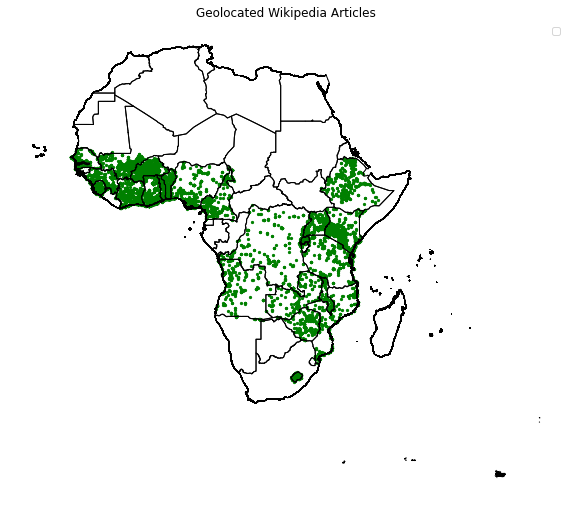

In [59]:
# Plot articles and clusters
shp = gpd.read_file(f'data/africa/Africa_Boundaries.shp') 

# plot
fig, ax = plt.subplots(figsize=(10, 10))
plot = shp.plot(ax=ax, color='none', edgecolor='black',zorder=2) # plot Adm 2 shapefile
for country, country_wiki in wikis.items():
    plot = ax.scatter(country_wiki['longitude'], country_wiki['latitude'],
                  c='green', s=5) 
    
# ax.scatter(dhs_clusts['lon'], dhs_clusts['lat'],
#                   c='red', s=5, label='DHS Clusters')
ax.spines['left'].set_visible(False) # hide all axes
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title(f'Geolocated Wikipedia Articles')
plt.legend()
plt.savefig(f'Wikis.png')
plt.show()

In [ ]:
#dhs_clusts.groupby(["country", "year"]).size()
country = 'ghana'
year = 2014

#country_wiki = pd.read_csv(f'articles/{country}_Wiki.csv')
country_clusts = country_clusts = dhs_clusts[(dhs_clusts['country']== country) & (dhs_clusts['year']== year)]
country_wiki['embedding'] = country_wiki['embedding'].apply(lambda x: np.fromstring(x[1:-1], 
                                                                                    sep=' '))